<a href="https://colab.research.google.com/github/manank572000-cyber/Fenicx-code/blob/main/Fenicsx_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# 1. Install FEniCSx (DOLFINx) and its dependencies
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh"
    !bash "/tmp/fenicsx-install.sh"
    import dolfinx

# 2. Verify the installation
from mpi4py import MPI
from dolfinx import mesh
import numpy as np

domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)
print("Mesh created successfully!")

Mesh created successfully!


Error_L2 : 8.24e-03
Error_max : 3.55e-15
static


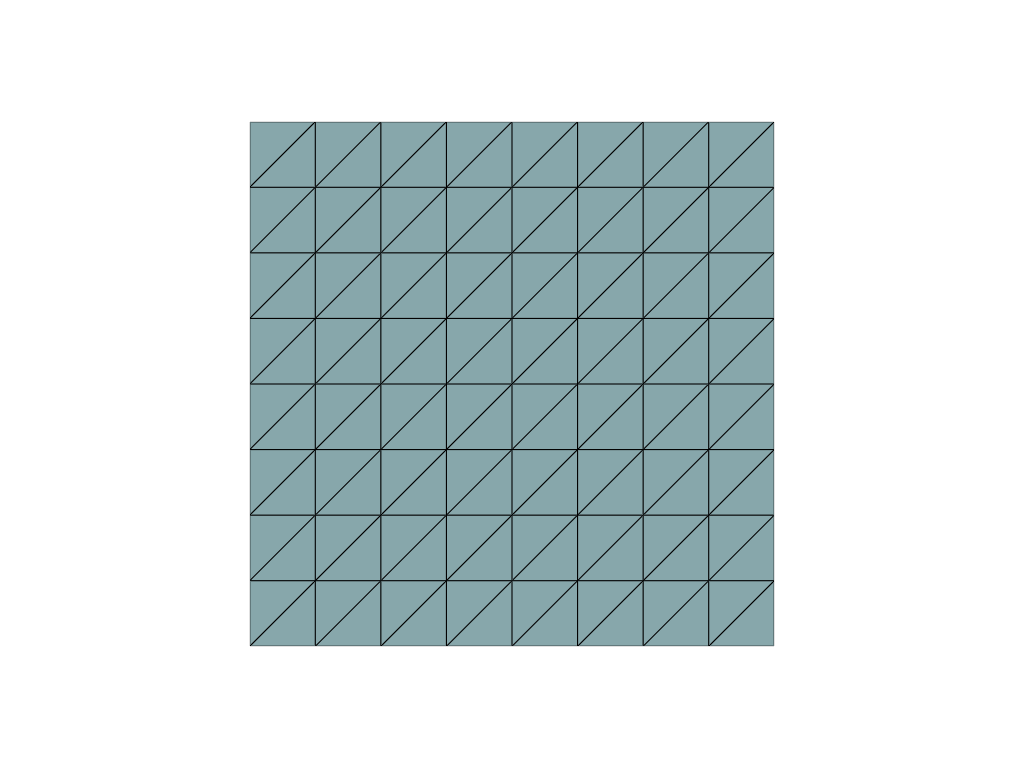

In [15]:
from mpi4py import MPI
from dolfinx import mesh
import numpy

domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)
from dolfinx import fem

V = fem.functionspace(domain, ("Lagrange", 1))
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)
import ufl

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
from dolfinx import default_scalar_type

f = fem.Constant(domain, default_scalar_type(-6))
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx
from dolfinx.fem.petsc import LinearProblem

problem = LinearProblem(
    a,
    L,
    bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    petsc_options_prefix="Poisson",
)
uh = problem.solve()
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2, name="u_exact")
uex.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
error_max = numpy.max(numpy.abs(uD.x.array - uh.x.array))
if domain.comm.rank == 0:  # Only print the error on one process
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")
    import pyvista

print(pyvista.global_theme.jupyter_backend)
from dolfinx import plot

domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

In [ ]:
!apt-get update -qq
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import pyvista

# Start the virtual screen
pyvista.start_xvfb()

# Use the 'static' backend for Colab compatibility
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True

In [ ]:
# ... (rest of your solver code) ...

import pyvista
from dolfinx import plot

# MANDATORY FOR COLAB
pyvista.start_xvfb()
pyvista.set_jupyter_backend('static')

domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

# Use show() to display the plot directly in the cell output
plotter.show()

In [ ]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

In [ ]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [ ]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()